## Biweekly Report 1

## Sentiment Classification with Convolutional Neural Networks

## Jake Watts

In this section of the report I define a CNN and use train it with the Sentiment Treebank data to classify sentences from movie reviews as either positive or negative. Creating the model was done with the help of the following tutorial https://towardsdatascience.com/cnn-sentiment-analysis-1d16b7c5a0e7.

In the model I also use a pre-trained word2vec model from google news for an embedding layer of the CNN.

In [6]:
import math
import numpy as np
import pandas as pd
from gensim import models
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model

Mounting my Google Drive and loading the pre-processed data.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_train = pd.read_pickle('/content/drive/My Drive/df_train.pkl')
df_test = pd.read_pickle('/content/drive/My Drive/df_test.pkl')

Downloading the google news vector. It took a while to figure out to do this, edning up finding this solution on StackOverflow. I also planned to compare the performance of this word2vec model with Gregor's word2vec model when used in the CNN, however we ran out of time to implement it for this week's report.

In [ ]:
!brew install wget

!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

/bin/bash: brew: command not found
--2022-01-24 01:02:43--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.169.77
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.169.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  34.7MB/s    in 75s     

2022-01-24 01:03:58 (21.0 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
!gzip -d GoogleNews-vectors-negative300.bin.gz

In [4]:
word2vec_path = "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

Getting training sentence lengths and training vocab.

In [9]:
all_training_words = [word for tokens in df_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in df_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))

Defining max sentence length and embedding dimensions.

In [10]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

Assigning each word to an integer and padding vectors to a uniform length.

In [11]:
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(df_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(df_train["Text_Final"].tolist())
train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))
train_cnn_data = pad_sequences(training_sequences, 
                               maxlen=MAX_SEQUENCE_LENGTH)

Found 14584 unique tokens.


Getting embedding from Google News model and saving embedding with words in the data.

In [12]:
train_embedding_weights = np.zeros((len(train_word_index)+1, 
 EMBEDDING_DIM))
for word,index in train_word_index.items():
 train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(14585, 300)


Pre-processing text data as well.

In [13]:
test_sequences = tokenizer.texts_to_sequences(df_test["Text_Final"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

Here I define the architecture of the CNN. 

In [14]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
 
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    convs = []
    filter_sizes = [2,3,4,5,6]
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200, 
                        kernel_size=filter_size, 
                        activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)
    l_merge = concatenate(convs, axis=1)
    x = Dropout(0.1)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)
    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

Since the model uses a sigmoid activation function I also visuzlize it below. The sigmoid function is defined as $y = \frac{1}{1+e^{-x}}$. As x increases it approaches one and as it decreases it approaches 0. 

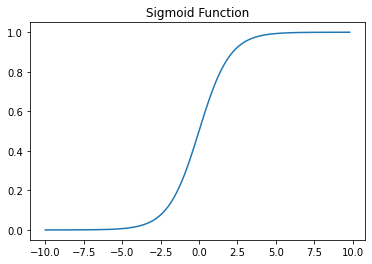

In [8]:
def sigmoid(x):
    a = []
    for item in x:
        a.append(1/(1+math.exp(-item)))
    return a

x = np.arange(-10., 10., 0.2)
plt.plot(x,sigmoid(x))
plt.title("Sigmoid Function")
plt.show()

Defining label names.

In [15]:
label_names = ['Pos', 'Neg']

Defining model and displaying the model summary. There are 4 convolutional layers and 4 max pooling layers to reduce the size of data while still retaining the most prominent features. There are also two dense layers with two dropout layers to prevent overfitting.

In [16]:
model = ConvNet(train_embedding_weights, 
                MAX_SEQUENCE_LENGTH, 
                len(train_word_index)+1, 
                EMBEDDING_DIM, 
                len(list(label_names)))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 300)      4375500     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 49, 200)      120200      ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 48, 200)      180200      ['embedding[0][0]']              
                                                                                              

Renaming data to x_train and y_train.

In [17]:
x_train = train_cnn_data
y_train = df_train[label_names].values

Now we can train the model! From the the training steps we can see that the training accuracy increases a but faster than the validation accuracy.

In [ ]:
num_epochs = 3
batch_size = 32
hist = model.fit(x_train, 
                 y_train, 
                 epochs=num_epochs, 
                 validation_split=0.1, 
                 shuffle=True, 
                 batch_size=batch_size)

Epoch 1/3
195/195 [==============================] - 11s 9ms/step - loss: 0.5381 - acc: 0.7197 - val_loss: 0.5161 - val_acc: 0.7442
Epoch 2/3
195/195 [==============================] - 1s 7ms/step - loss: 0.3356 - acc: 0.8561 - val_loss: 0.4979 - val_acc: 0.7384
Epoch 3/3
195/195 [==============================] - 1s 7ms/step - loss: 0.1893 - acc: 0.9282 - val_loss: 0.5244 - val_acc: 0.8121


Predicting on the test accuracy reveals an accuracy level of 78%.

In [ ]:
predictions = model.predict(test_cnn_data, batch_size=1024, verbose=1)

2/2 [==============================] - 0s 99ms/step


In [21]:
labels = [1, 0]

In [ ]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [ ]:
sum(df_test.Pos==prediction_labels)/len(prediction_labels)

0.7825370675453048

Since there are only two categories in the testing data we should check if they are balanced as this would effect the interpretation of the model accuracy. It appears that approximately 50% of the data falls in each category. Therefore we would expect a model guessing randomly to predict 50% of the data correctly. This implies the CNN predictions are better than random.

In [ ]:
df_test.Pos.value_counts()

0    912
1    909
Name: Pos, dtype: int64

Finally, I wanted to try increasing the number of epochs to see if it improves model performance. 

In [18]:
num_epochs = 10
batch_size = 32
hist2 = model.fit(x_train, 
                 y_train, 
                 epochs=num_epochs, 
                 validation_split=0.1, 
                 shuffle=True, 
                 batch_size=batch_size)

Epoch 1/10
195/195 [==============================] - 12s 11ms/step - loss: 0.5471 - acc: 0.7205 - val_loss: 0.4496 - val_acc: 0.8064
Epoch 2/10
195/195 [==============================] - 2s 9ms/step - loss: 0.3424 - acc: 0.8521 - val_loss: 0.4151 - val_acc: 0.8223
Epoch 3/10
195/195 [==============================] - 2s 9ms/step - loss: 0.1950 - acc: 0.9282 - val_loss: 0.3913 - val_acc: 0.8353
Epoch 4/10
195/195 [==============================] - 2s 9ms/step - loss: 0.1001 - acc: 0.9640 - val_loss: 0.5441 - val_acc: 0.8092
Epoch 5/10
195/195 [==============================] - 2s 9ms/step - loss: 0.0538 - acc: 0.9820 - val_loss: 0.7314 - val_acc: 0.7572
Epoch 6/10
195/195 [==============================] - 2s 9ms/step - loss: 0.0364 - acc: 0.9881 - val_loss: 0.8917 - val_acc: 0.7702
Epoch 7/10
195/195 [==============================] - 2s 9ms/step - loss: 0.0256 - acc: 0.9905 - val_loss: 0.6088 - val_acc: 0.8280
Epoch 8/10
195/195 [==============================] - 2s 9ms/step - loss: 

The plot below shows evidence that there may be overfitting while training the data as the validation accuracy only appears to improve with the training accuracy for the first few epochs.

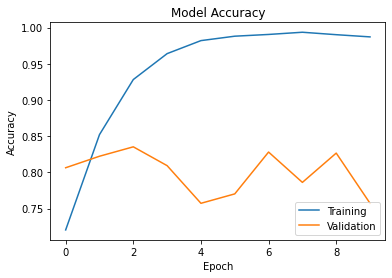

In [27]:
plt.figure()
plt.plot(hist2.history['acc'])
plt.plot(hist2.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

Looking at the test predictions it appears that the accuracy of the prediction decreased from 78% to 75%.

In [19]:
predictions = model.predict(test_cnn_data, batch_size=1024, verbose=1)

2/2 [==============================] - 0s 100ms/step


In [22]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [23]:
sum(df_test.Pos==prediction_labels)/len(prediction_labels)

0.7594728171334432

Here we can view the dataset and compare the true sentiment (Pos) with the predicted sentiment (pred).

In [40]:
df_test['pred'] = prediction_labels
df_test[['Text_Final', 'Pos', 'pred']].head(20)

,Text_Final,Pos,pred
1,sometimes like go movies fun wasabi good place...,1,1
2,emerges something rare issue movie honest keen...,1,1
4,offers rare combination entertainment education,1,1
5,perhaps picture ever made literally showed roa...,1,1
6,steers turns snappy screenplay curls edges cle...,1,1
7,somehow pulls,1,1
8,take care cat offers refreshingly different sl...,1,1
9,film well worth seeing talking singing heads,1,1
10,really surprises wisegirls lowkey quality genu...,1,1
11,wendigo go cinema fed eye heart mind,1,1


We can also filter to see only cases in which the predictions to not match. However there doesn't seem to be much of a difference between the sentences which match and don't match.

In [42]:
df_test2 = df_test[df_test['Pos'] != df_test['pred']]
df_test2[['Text_Final', 'Pos', 'pred']].head(20)

,Text_Final,Pos,pred
23,scores points dedicated goodhearted profession...,1,0
27,however lacks grandeur epic quality often asso...,0,1
34,though everything might literate smart never t...,0,1
36,ms fulfordwierzbicki almost spooky sulky calcu...,1,0
38,like bond outings recent years stunts outlandi...,0,1
64,son bride may good halfhour long comes replete...,0,1
75,absorbing disturbing perhaps disturbing origin...,0,1
89,like film almost anthropologically detailed re...,1,0
90,mcfarlane animation lifts film firmly level co...,0,1
100,surface loversontherun crime flick lot common ...,1,0


## Summary

The CNN model appears to have done a good job at predicting the sentiment for the reviews although there is some room for improvement. In future reports I may want to attempt to classify strongly positive/negative and nuetral statements as well and also compare the results from the CNN to different models.

It also seems that training for too many epoch on this data can cause overfitting leading to a decrease in model performance.